In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
## Imports
import warnings
warnings.filterwarnings('ignore')

import sys

if "google.colab" in sys.modules:
    !pip uninstall lightgbm -y
    !pip install lightgbm==3.3.1
    !pip install Levenshtein

import os
import gc
import time
import random
import pickle
import Levenshtein
import difflib
import multiprocessing
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import lightgbm as lgb
from tqdm.auto import tqdm
from requests import get
from collections import Counter, defaultdict
from sklearn.model_selection import GroupKFold, StratifiedKFold
from sklearn.neighbors import KNeighborsRegressor
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.neighbors import NearestNeighbors

Found existing installation: lightgbm 2.2.3
Uninstalling lightgbm-2.2.3:
  Successfully uninstalled lightgbm-2.2.3
     |████████████████████████████████| 2.0 MB 4.1 MB/s 
     |████████████████████████████████| 258 kB 4.1 MB/s 
     |████████████████████████████████| 1.8 MB 53.5 MB/s 
     |████████████████████████████████| 103 kB 70.4 MB/s 


In [ ]:
def stratified_group_k_fold(X, y, groups, k, seed=None):
    labels_num = np.max(y) + 1
    y_counts_per_group = defaultdict(lambda: np.zeros(labels_num))
    y_distr = Counter()
    for label, g in zip(y, groups):
        y_counts_per_group[g][label] += 1
        y_distr[label] += 1

    y_counts_per_fold = defaultdict(lambda: np.zeros(labels_num))
    groups_per_fold = defaultdict(set)

    def eval_y_counts_per_fold(y_counts, fold):
        y_counts_per_fold[fold] += y_counts
        std_per_label = []
        for label in range(labels_num):
            label_std = np.std([y_counts_per_fold[i][label] / y_distr[label] for i in range(k)])
            std_per_label.append(label_std)
        y_counts_per_fold[fold] -= y_counts
        return np.mean(std_per_label)
    
    groups_and_y_counts = list(y_counts_per_group.items())
    random.Random(seed).shuffle(groups_and_y_counts)

    for g, y_counts in sorted(groups_and_y_counts, key=lambda x: -np.std(x[1])):
        best_fold = None
        min_eval = None
        for i in range(k):
            fold_eval = eval_y_counts_per_fold(y_counts, i)
            if min_eval is None or fold_eval < min_eval:
                min_eval = fold_eval
                best_fold = i
        y_counts_per_fold[best_fold] += y_counts
        groups_per_fold[best_fold].add(g)

    all_groups = set(groups)
    for i in range(k):
        train_groups = all_groups - groups_per_fold[i]
        test_groups = groups_per_fold[i]

        train_indices = [i for i, g in enumerate(groups) if g in train_groups]
        test_indices = [i for i, g in enumerate(groups) if g in test_groups]

        yield train_indices, test_indices

In [ ]:
def get_distribution(y_vals):
    y_distr = Counter(y_vals)
    y_vals_sum = sum(y_distr.values())
    return [f'{y_distr[i] / y_vals_sum:.2%}' for i in range(np.max(y_vals) + 1)]

In [ ]:
## Parameters
class CFG:
    AUTHOR = "kuruton"
    expID = ""
    if "google.colab" in sys.modules:
        expID = get("http://172.28.0.2:9000/api/sessions").json()[0]["name"].split(".")[0].split("-")[0]
    ROOT_DIR = '/content/drive/MyDrive/Kaggle/Foursquare'
    DATASET_DIR = os.path.join(ROOT_DIR, 'Dataset')
    INPUT_DIR = os.path.join(ROOT_DIR, 'Input')
    OUTPUT_DIR = os.path.join(ROOT_DIR, 'Output')
    is_debug = False
    SEED = 2022
    num_neighbors = 20
    num_split = 6
    feat_columns = ['name', 'address', 'city', 
                'state', 'zip', 'url', 
              'phone', 'categories', 'country']
    vec_columns = ['name', 'categories', 'address', 
                  'state', 'url', 'country']

def seed_everything(seed):
    random.seed(seed)
    np.random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    
seed_everything(CFG.SEED)

In [ ]:
if not os.path.exists(os.path.join(CFG.OUTPUT_DIR, CFG.expID)):
    os.makedirs(os.path.join(CFG.OUTPUT_DIR, CFG.expID))

In [ ]:
%load_ext Cython

In [ ]:
%%cython
def LCS(str S, str T):
    cdef int i, j
    cdef list dp = [[0] * (len(T) + 1) for _ in range(len(S) + 1)]
    for i in range(len(S)):
        for j in range(len(T)):
            dp[i + 1][j + 1] = max(dp[i][j] + (S[i] == T[j]), dp[i + 1][j], dp[i][j + 1], dp[i + 1][j + 1])
    return dp[len(S)][len(T)]

In [ ]:
def recall_knn(df, Neighbors = 10):
    print('Start knn grouped by country')
    train_df_country = []
    for country, country_df in tqdm(df.groupby('country')):
        country_df = country_df.reset_index(drop = True)

        neighbors = min(len(country_df), Neighbors)
        knn = KNeighborsRegressor(n_neighbors = neighbors,
                                    metric = 'haversine',
                                    n_jobs = -1)
        knn.fit(country_df[['latitude','longitude']], country_df.index)
        dists, nears = knn.kneighbors(country_df[['latitude', 'longitude']], 
                                        return_distance = True)

        for k in range(neighbors):            
            cur_df = country_df[['id', 'point_of_interest', 'fold']]
            cur_df['match_id'] = country_df['id'].values[nears[:, k]]
            cur_df['kdist_country'] = dists[:, k]
            cur_df['kneighbors_country'] = k
            
            train_df_country.append(cur_df)
    train_df_country = pd.concat(train_df_country)
    
    print('Start knn')
    train_df = []
    knn = NearestNeighbors(n_neighbors = Neighbors)
    knn.fit(df[['latitude','longitude']], df.index)
    dists, nears = knn.kneighbors(df[['latitude','longitude']])
    
    for k in range(Neighbors):            
        cur_df = df[['id']]
        cur_df['match_id'] = df['id'].values[nears[:, k]]
        cur_df['kdist'] = dists[:, k]
        cur_df['kneighbors'] = k
        train_df.append(cur_df)
    
    train_df = pd.concat(train_df)
    train_df = train_df.merge(train_df_country,
                                 on = ['id', 'match_id'],
                                 how = 'outer')
    del train_df_country
    
    return train_df

In [ ]:
def add_features(df):    
    for col in tqdm(CFG.feat_columns):       
        if col in CFG.vec_columns:
            tv_fit = tfidf_d[col]
            indexs = [id2index_d[i] for i in df['id']]
            match_indexs = [id2index_d[i] for i in df['match_id']]                    
            df[f'{col}_sim'] = tv_fit[indexs].multiply(tv_fit[match_indexs]).sum(axis = 1).A.ravel()
        
        col_values = data.loc[df['id']][col].values.astype(str)
        matcol_values = data.loc[df['match_id']][col].values.astype(str)
        
        geshs = []
        levens = []
        jaros = []
        lcss = []
        for s, match_s in zip(col_values, matcol_values):
            if s != 'nan' and match_s != 'nan':                    
                geshs.append(difflib.SequenceMatcher(None, s, match_s).ratio())
                levens.append(Levenshtein.distance(s, match_s))
                jaros.append(Levenshtein.jaro_winkler(s, match_s))
                lcss.append(LCS(str(s), str(match_s)))
            else:
                geshs.append(np.nan)
                levens.append(np.nan)
                jaros.append(np.nan)
                lcss.append(np.nan)
        
        df[f'{col}_gesh'] = geshs
        df[f'{col}_leven'] = levens
        df[f'{col}_jaro'] = jaros
        df[f'{col}_lcs'] = lcss
        
        if col not in ['phone', 'zip']:
            df[f'{col}_len'] = list(map(len, col_values))
            df[f'match_{col}_len'] = list(map(len, matcol_values)) 
            df[f'{col}_len_diff'] = np.abs(df[f'{col}_len'] - df[f'match_{col}_len'])
            df[f'{col}_nleven'] = df[f'{col}_leven'] / \
                                    df[[f'{col}_len', f'match_{col}_len']].max(axis = 1)
            
            df[f'{col}_nlcsk'] = df[f'{col}_lcs'] / df[f'match_{col}_len']
            df[f'{col}_nlcs'] = df[f'{col}_lcs'] / df[f'{col}_len']
            
            df = df.drop(f'{col}_len', axis = 1)
            df = df.drop(f'match_{col}_len', axis = 1)
            gc.collect()
            
    return df

In [ ]:
def get_id2poi(input_df: pd.DataFrame) -> dict:
    return dict(zip(input_df['id'], input_df['point_of_interest']))

def get_poi2ids(input_df: pd.DataFrame) -> dict:
    return input_df.groupby('point_of_interest')['id'].apply(set).to_dict()

def get_score(input_df: pd.DataFrame):
    scores = []
    for id_str, matches in zip(input_df['id'].to_numpy(), input_df['matches'].to_numpy()):
        targets = poi2ids[id2poi[id_str]]
        preds = set(matches.split())
        score = len((targets & preds)) / len((targets | preds))
        scores.append(score)
    scores = np.array(scores)
    return scores.mean()

def analysis(df):
    print('Num of data: %s' % len(df))
    print('Num of unique id: %s' % df['id'].nunique())
    print('Num of unique poi: %s' % df['point_of_interest'].nunique())
    
    poi_grouped = df.groupby('point_of_interest')['id'].count().reset_index()
    print('Mean num of unique poi: %s' % poi_grouped['id'].mean())

In [ ]:
## Data load
if "google.colab" in sys.modules:
    data_root = CFG.INPUT_DIR
else:
    data_root = '../input/foursquare-location-matching'
data = pd.read_csv(os.path.join(data_root, 'train.csv'))

if CFG.is_debug:
    data = data.sample(n = 10000, random_state = CFG.SEED)
    data = data.reset_index(drop = True)

# split fold

In [ ]:
data['POI_count'] = data['point_of_interest'].map(dict(data.groupby('point_of_interest')['id'].apply(len)))
data.loc[data['POI_count'] > 5, 'POI_count'] = 5
data['POI_count'] -= 1
data.head()

,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count
0,E_000001272c6c5d,Café Stad Oudenaarde,50.859975,3.634196,Abdijstraat,Nederename,Oost-Vlaanderen,9700,BE,NaN,NaN,Bars,P_677e840bb6fc7e,1
1,E_000002eae2a589,Carioca Manero,-22.907225,-43.178244,NaN,NaN,NaN,NaN,BR,NaN,NaN,Brazilian Restaurants,P_d82910d8382a83,1
2,E_000007f24ebc95,ร้านตัดผมการาเกด,13.780813,100.484900,NaN,NaN,NaN,NaN,TH,NaN,NaN,Salons / Barbershops,P_b1066599e78477,0
3,E_000008a8ba4f48,Turkcell,37.844510,27.844202,Adnan Menderes Bulvarı,NaN,NaN,NaN,TR,NaN,NaN,Mobile Phone Shops,P_b2ed86905a4cd3,0
4,E_00001d92066153,Restaurante Casa Cofiño,43.338196,-4.326821,NaN,Caviedes,Cantabria,NaN,ES,NaN,NaN,Spanish Restaurants,P_809a884d4407fb,1


In [ ]:
distrs = [get_distribution(data['POI_count'])]
index = ['training set']

for fold_ind, (dev_ind, val_ind) in enumerate(stratified_group_k_fold(data, data['POI_count'], data["point_of_interest"], k=CFG.num_split, seed=CFG.SEED)):
    data.loc[val_ind, "fold"] = fold_ind

    dev_y, val_y = data.loc[dev_ind, 'POI_count'], data.loc[val_ind, 'POI_count']
    dev_groups, val_groups = data.loc[dev_ind, "point_of_interest"], data.loc[val_ind, "point_of_interest"]
    
    assert len(set(dev_groups) & set(val_groups)) == 0
    
    distrs.append(get_distribution(dev_y))
    index.append(f'development set - fold {fold_ind}')
    distrs.append(get_distribution(val_y))
    index.append(f'validation set - fold {fold_ind}')

display('Distribution per class:')
pd.DataFrame(distrs, index=index, columns=[f'Label {l}' for l in range(np.max(data['POI_count']) + 1)])

'Distribution per class:'

,Label 0,Label 1,Label 2,Label 3,Label 4
training set,37.32%,48.77%,6.38%,2.09%,5.44%
development set - fold 0,37.32%,48.77%,6.38%,2.09%,5.44%
validation set - fold 0,37.32%,48.77%,6.38%,2.09%,5.44%
development set - fold 1,37.32%,48.77%,6.38%,2.09%,5.44%
validation set - fold 1,37.32%,48.77%,6.38%,2.09%,5.44%
development set - fold 2,37.32%,48.77%,6.38%,2.09%,5.44%
validation set - fold 2,37.32%,48.77%,6.38%,2.09%,5.44%
development set - fold 3,37.32%,48.77%,6.38%,2.09%,5.44%
validation set - fold 3,37.32%,48.77%,6.38%,2.08%,5.44%
development set - fold 4,37.32%,48.77%,6.38%,2.09%,5.44%


In [ ]:
## Data split
# kf = GroupKFold(n_splits=2)
# for i, (trn_idx, val_idx) in enumerate(kf.split(data, 
#                                                 data['point_of_interest'], 
#                                                 data['point_of_interest'])):
#     data.loc[val_idx, 'set'] = i

data['set'] = 1
data.loc[data['fold'].isin(list(range(CFG.num_split // 2))), 'set'] = 0

print('Num of train data: %s' % len(data))
print(data['set'].value_counts())

valid_data = data[data['set'] == 0]
train_data = data[data['set'] == 1]

print('Train data: ')
analysis(train_data)
print('Valid data: ')
analysis(valid_data)

train_poi = train_data['point_of_interest'].unique().tolist()
valid_poi = valid_data['point_of_interest'].unique().tolist()

print(set(train_poi) & set(valid_poi))

train_ids = train_data['id'].unique().tolist()
valid_ids = valid_data['id'].unique().tolist()
      
print(set(train_ids) & set(valid_ids))
      
tv_ids_d = {}
tv_ids_d['train_ids'] = train_ids
tv_ids_d['valid_ids'] = valid_ids

np.save('tv_ids_d.npy', tv_ids_d)

del train_data, valid_data
gc.collect()

data = data.set_index('id')
# data = data.loc[tv_ids_d['train_ids']]
data = data.reset_index()

Num of train data: 1138812
0    569412
1    569400
Name: set, dtype: int64
Train data: 
Num of data: 569400
Num of unique id: 569400
Num of unique poi: 369985
Mean num of unique poi: 1.5389813100531102
Valid data: 
Num of data: 569412
Num of unique id: 569412
Num of unique poi: 369987
Mean num of unique poi: 1.5390054245149154
set()
set()


In [ ]:
## Train data generated by knn
id2index_d = dict(zip(data['id'].values, data.index))

tfidf_d = {}
for col in CFG.vec_columns:
    tfidf = TfidfVectorizer()
    tv_fit = tfidf.fit_transform(data[col].fillna('nan'))
    tfidf_d[col] = tv_fit

train_data = pd.concat([
    recall_knn(data[data["set"]==0], CFG.num_neighbors), 
    recall_knn(data[data["set"]==1], CFG.num_neighbors), 
])

data = data.set_index('id')
ids = train_data['id'].tolist()
match_ids = train_data['match_id'].tolist()

poi = data.loc[ids]['point_of_interest'].values
match_poi = data.loc[match_ids]['point_of_interest'].values

train_data['label'] = np.array(poi == match_poi, dtype = np.int8)
del poi, match_poi, ids, match_ids
gc.collect()

print('Num of unique id: %s' % train_data['id'].nunique())
print('Num of train data: %s' % len(train_data))
print('Pos rate: %s' % train_data['label'].mean())
print(train_data.sample(5))

Start knn grouped by country


  0%|          | 0/208 [00:00<?, ?it/s]

Start knn
Start knn grouped by country


  0%|          | 0/211 [00:00<?, ?it/s]

Start knn
Num of unique id: 1138812
Num of train data: 27840522
Pos rate: 0.07229659702501268
                        id          match_id     kdist  kneighbors  \
2702179   E_be7e78dd907dc6  E_ab9c1fdc92b3ff  0.000868         4.0   
12689860  E_39a1807e42dd21  E_4a3a5a57a0b24d       NaN         NaN   
2399883   E_36eb34a95417a0  E_a408cc1429dacd  0.002765         4.0   
4890065   E_962c01a48835cc  E_f13b1e405eef05  0.221481         8.0   
5420807   E_855ae1fbc35bcc  E_89bc27494c8bf0  0.002518         9.0   

         point_of_interest  fold  kdist_country  kneighbors_country  label  
2702179   P_78e67cd5f18f78   5.0       0.000806                15.0      0  
12689860  P_0182d6deedb355   5.0       0.001723                16.0      0  
2399883   P_ae588f75182be9   1.0       0.002371                 4.0      0  
4890065   P_b09fc60aecf4cb   3.0       0.221323                17.0      0  
5420807   P_bc353981ea7116   1.0       0.001585                 5.0      0  


In [ ]:
## Eval
data = data.reset_index()

id2poi = get_id2poi(data)
poi2ids = get_poi2ids(data)

eval_df = pd.DataFrame()
eval_df['id'] = data['id'].unique().tolist()
eval_df['match_id'] = eval_df['id']
print('Unique id: %s' % len(eval_df))

eval_df_ = train_data[train_data['label'] == 1][['id', 'match_id']]
eval_df = pd.concat([eval_df, eval_df_])

eval_df = eval_df.groupby('id')['match_id'].\
                        apply(list).reset_index()
eval_df['matches'] = eval_df['match_id'].apply(lambda x: ' '.join(set(x)))
print('Unique id: %s' % len(eval_df))

iou_score = get_score(eval_df)
print('IoU score: %s' % iou_score)

Unique id: 1138812
Unique id: 1138812
IoU score: 0.9226622242687487


# model learning

In [ ]:
data = data.set_index('id')
# train_data = add_features(train_data)

In [ ]:
train_data['kdist_diff'] = (train_data['kdist'] - train_data['kdist_country']) /\
                            train_data['kdist_country']
train_data['kneighbors_mean'] = train_data[['kneighbors', 'kneighbors_country']].mean(axis = 1)

In [ ]:
features = ['kdist','kneighbors','kdist_country','kneighbors_country', 'kdist_diff', 'kneighbors_mean']

columns = ['name', 'address', 'city', 'state',
       'zip', 'country', 'url', 'phone', 'categories']

for c in columns:
    if c == 'country':
        features += ['country_leven', 'country_sim', 'country_gesh', 'country_nleven']
        continue
    features += [f"{c}_gesh", f"{c}_jaro", f"{c}_lcs", f"{c}_leven"]
    if c == 'city':
        features += [f"{c}_len_diff", f"{c}_nleven", f"{c}_nlcsk", f"{c}_nlcs"]
    if c in ['address', 'categories', 'country', 'name', 'state', 'url']:
        features += [f"{c}_len_diff", f"{c}_nleven", f"{c}_nlcsk", f"{c}_nlcs", f"{c}_sim"]

print(len(features))
print(features)

71
['kdist', 'kneighbors', 'kdist_country', 'kneighbors_country', 'kdist_diff', 'kneighbors_mean', 'name_gesh', 'name_jaro', 'name_lcs', 'name_leven', 'name_len_diff', 'name_nleven', 'name_nlcsk', 'name_nlcs', 'name_sim', 'address_gesh', 'address_jaro', 'address_lcs', 'address_leven', 'address_len_diff', 'address_nleven', 'address_nlcsk', 'address_nlcs', 'address_sim', 'city_gesh', 'city_jaro', 'city_lcs', 'city_leven', 'city_len_diff', 'city_nleven', 'city_nlcsk', 'city_nlcs', 'state_gesh', 'state_jaro', 'state_lcs', 'state_leven', 'state_len_diff', 'state_nleven', 'state_nlcsk', 'state_nlcs', 'state_sim', 'zip_gesh', 'zip_jaro', 'zip_lcs', 'zip_leven', 'country_leven', 'country_sim', 'country_gesh', 'country_nleven', 'url_gesh', 'url_jaro', 'url_lcs', 'url_leven', 'url_len_diff', 'url_nleven', 'url_nlcsk', 'url_nlcs', 'url_sim', 'phone_gesh', 'phone_jaro', 'phone_lcs', 'phone_leven', 'categories_gesh', 'categories_jaro', 'categories_lcs', 'categories_leven', 'categories_len_diff', 'c

In [ ]:
def fit_lgb(X, y, params=None, es_rounds=20, seed=42, N_SPLITS=5, 
             n_class=None, model_dir=None, folds=None):
    models = []

    trn_idx = np.isin(folds, list(range(CFG.num_split // 2)))
    val_idx = np.isin(folds, list(range(CFG.num_split // 2, CFG.num_split - 1)))
    X_train, y_train = X[trn_idx], y.iloc[trn_idx]
    X_valid, y_valid = X.iloc[val_idx], y.iloc[val_idx]
    X_train = add_features(X_train)
    X_valid = add_features(X_valid)
    X_train = X_train[features]
    X_valid = X_valid[features]

    if model_dir is None:
        model = lgb.LGBMClassifier(**params)
        model.fit(
            X_train, y_train, 
            eval_set=[(X_valid, y_valid)],  
            early_stopping_rounds=es_rounds, 
            eval_metric='binary',  
#             verbose=-1)
            verbose=50)
    else:
        with open(f'{model_dir}/lgb_fold{i}.pkl', 'rb') as f:
            model = pickle.load(f)
        
    oof = model.predict_proba(X_valid)
    models.append(model)
    
    file = os.path.join(CFG.OUTPUT_DIR, os.path.join(CFG.expID, f'lgb_fold.pkl'))
    pickle.dump(model, open(file, 'wb'))
    print()

    del X_train, X_valid
    gc.collect()

    cv = (oof.argmax(axis=-1) == y_valid).mean()
    print(f"CV-accuracy: {cv}")

    return oof, models

def inference_lgb(models, feat_df):
    pred = np.array([model.predict_proba(feat_df) for model in models])
    pred = np.mean(pred, axis=0)
    return pred

In [ ]:
params = {
    'objective': "binary",
    'learning_rate': 0.2,
    'reg_alpha': 0.1,
    'reg_lambda': 0.1,
    'random_state': 42,

    'max_depth': 7,   
    'num_leaves': 35, 
    'n_estimators': 1000000, 
    "colsample_bytree": 0.9,
}


oof, models = fit_lgb(train_data, train_data["label"].astype(int), 
                      params=params, n_class=2, 
                      N_SPLITS=CFG.num_split, folds=train_data["fold"].values)

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

[50]	valid_0's binary_logloss: 0.0494028
[100]	valid_0's binary_logloss: 0.0477286
[150]	valid_0's binary_logloss: 0.0471543
[200]	valid_0's binary_logloss: 0.0468764
[250]	valid_0's binary_logloss: 0.0464925
[300]	valid_0's binary_logloss: 0.046279
[350]	valid_0's binary_logloss: 0.0461257
[400]	valid_0's binary_logloss: 0.046057
[450]	valid_0's binary_logloss: 0.0459527
[500]	valid_0's binary_logloss: 0.045844
[550]	valid_0's binary_logloss: 0.0457568
[600]	valid_0's binary_logloss: 0.0457226
[650]	valid_0's binary_logloss: 0.0456762
[700]	valid_0's binary_logloss: 0.0456135
[750]	valid_0's binary_logloss: 0.0455626

CV-accuracy: 0.9838652522691713


In [ ]:
train_data["pred"] = -1
val_idx = np.isin(train_data["fold"].values, list(range(CFG.num_split // 2, CFG.num_split - 1)))
train_data.loc[val_idx, "pred"] = oof[:, -1]

In [ ]:
train_data.groupby('fold')["pred"].mean()

fold
0.0   -1.000000
1.0   -1.000000
2.0   -1.000000
3.0    0.086252
4.0    0.086517
5.0   -1.000000
Name: pred, dtype: float64

In [ ]:
feat_df = add_features(train_data.loc[train_data["fold"] == CFG.num_split - 1, :])[features]
train_data.loc[train_data["fold"] == CFG.num_split - 1, "pred"] = inference_lgb(models, feat_df)[:, -1]

  0%|          | 0/9 [00:00<?, ?it/s]

In [ ]:
train_data.groupby('fold')["pred"].mean()

fold
0.0   -1.000000
1.0   -1.000000
2.0   -1.000000
3.0    0.086252
4.0    0.086517
5.0    0.086458
Name: pred, dtype: float64

In [ ]:
del feat_df
gc.collect()

124

In [ ]:
train_data = train_data.iloc[np.isin(train_data["fold"].values, list(range(CFG.num_split // 2, CFG.num_split)))]
gc.collect()

50

In [ ]:
out_df = pd.DataFrame()
out_df['id'] = train_data['id'].unique().tolist()
out_df['match_id'] = out_df['id']

#Check Feature Importances

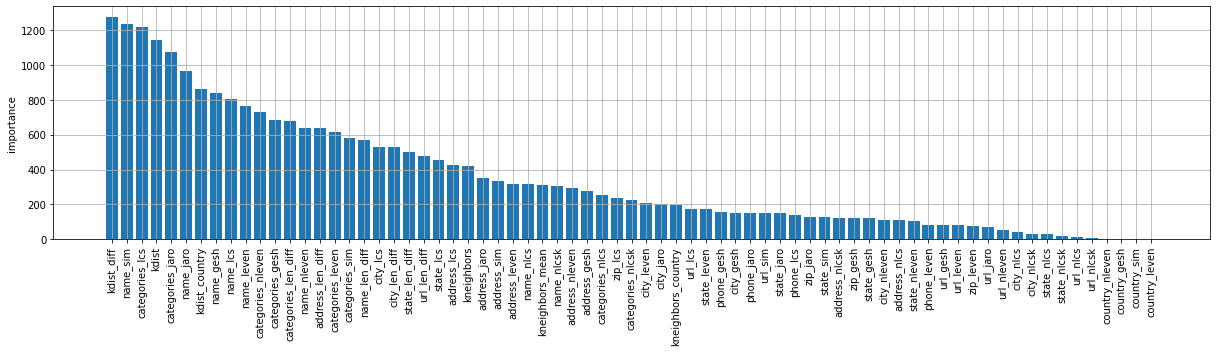

In [ ]:
def plot_importances(models):
    importance_df = pd.DataFrame(models[0].feature_importances_, 
                                 index=features, 
                                 columns=['importance'])\
                        .sort_values("importance", ascending=False)

    plt.subplots(figsize=(len(features) // 4, 5))
    plt.bar(importance_df.index, importance_df.importance)
    plt.grid()
    plt.xticks(rotation=90)
    plt.ylabel("importance")
    plt.tight_layout()
    plt.show()

plot_importances(models)

#Check CV

In [ ]:
!pip install optuna

     |████████████████████████████████| 308 kB 4.1 MB/s 
     |████████████████████████████████| 81 kB 7.6 MB/s 
     |████████████████████████████████| 210 kB 57.6 MB/s 
     |████████████████████████████████| 78 kB 6.1 MB/s 
     |████████████████████████████████| 49 kB 5.4 MB/s 
     |████████████████████████████████| 112 kB 9.3 MB/s 
     |████████████████████████████████| 146 kB 47.4 MB/s 
  Created wheel for pyperclip: filename=pyperclip-1.8.2-py3-none-any.whl size=11137 sha256=036793758f6e6098a3fa74a73873c17eb2d0a09763b9d5cdc129fc8ce9c43980
  Stored in directory: /root/.cache/pip/wheels/9f/18/84/8f69f8b08169c7bae2dde6bd7daf0c19fca8c8e500ee620a28
Successfully built pyperclip


In [ ]:
def post_process(df):
    id2match = dict(zip(df['id'].values, df['matches'].str.split()))

    for base, match in df[['id', 'matches']].values:
        match = match.split()
        if len(match) == 1:        
            continue

        for m in match:
            if base not in id2match[m]:
                id2match[m].append(base)
    df['matches'] = df['id'].map(id2match).map(' '.join)
    return df 

In [33]:
import optuna

def objective(trial):
    x = trial.suggest_uniform('threshold', 0, 1)
    train_pred_df = train_data[train_data['pred'] > x][['id', 'match_id']]
    out_df = pd.DataFrame()
    out_df['id'] = train_data['id'].unique().tolist()
    out_df['match_id'] = out_df['id']
    out_df = pd.concat([out_df, train_pred_df])
    out_df = out_df.groupby('id')['match_id'].\
                        apply(list).reset_index()
    out_df['matches'] = out_df['match_id'].apply(lambda x: ' '.join(set(x)))
    out_df = post_process(out_df)

    score = get_score(out_df)
    print(f"CV: {score:.6f}")
    return score

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100)

[I 2022-05-22 09:01:43,246] A new study created in memory with name: no-name-75c32dfc-2afa-4557-a630-97e38e7bbefe
[I 2022-05-22 09:02:01,466] Trial 0 finished with value: 0.6607277942877857 and parameters: {'threshold': 0.9989570672542447}. Best is trial 0 with value: 0.6607277942877857.


CV: 0.660728


[I 2022-05-22 09:02:21,365] Trial 1 finished with value: 0.8017926028136564 and parameters: {'threshold': 0.22052620404273082}. Best is trial 1 with value: 0.8017926028136564.


CV: 0.801793


[I 2022-05-22 09:02:41,347] Trial 2 finished with value: 0.8246871285084632 and parameters: {'threshold': 0.41827440880355116}. Best is trial 2 with value: 0.8246871285084632.


CV: 0.824687


[I 2022-05-22 09:03:00,741] Trial 3 finished with value: 0.8114439167076218 and parameters: {'threshold': 0.2729868841508518}. Best is trial 2 with value: 0.8246871285084632.


CV: 0.811444


[I 2022-05-22 09:03:19,887] Trial 4 finished with value: 0.8134979046335803 and parameters: {'threshold': 0.7658419510045954}. Best is trial 2 with value: 0.8246871285084632.


CV: 0.813498


[I 2022-05-22 09:03:39,390] Trial 5 finished with value: 0.8249158361752813 and parameters: {'threshold': 0.6243822014019614}. Best is trial 5 with value: 0.8249158361752813.


CV: 0.824916


[I 2022-05-22 09:03:57,367] Trial 6 finished with value: 0.7594330212546393 and parameters: {'threshold': 0.938540511190663}. Best is trial 5 with value: 0.8249158361752813.


CV: 0.759433


[I 2022-05-22 09:04:16,990] Trial 7 finished with value: 0.8252152742790182 and parameters: {'threshold': 0.6149422667047558}. Best is trial 7 with value: 0.8252152742790182.


CV: 0.825215


[I 2022-05-22 09:04:36,814] Trial 8 finished with value: 0.8268982503198098 and parameters: {'threshold': 0.5347411554977657}. Best is trial 8 with value: 0.8268982503198098.


CV: 0.826898


[I 2022-05-22 09:04:55,382] Trial 9 finished with value: 0.8203851077884885 and parameters: {'threshold': 0.6998981266657329}. Best is trial 8 with value: 0.8268982503198098.


CV: 0.820385


[I 2022-05-22 09:05:17,623] Trial 10 finished with value: 0.6987099650990269 and parameters: {'threshold': 0.04647777813786047}. Best is trial 8 with value: 0.8268982503198098.


CV: 0.698710


[I 2022-05-22 09:05:46,866] Trial 11 finished with value: 0.8268464602913173 and parameters: {'threshold': 0.4929300171680835}. Best is trial 8 with value: 0.8268982503198098.


CV: 0.826846


[I 2022-05-22 09:06:06,109] Trial 12 finished with value: 0.825827361721186 and parameters: {'threshold': 0.4465920232715933}. Best is trial 8 with value: 0.8268982503198098.


CV: 0.825827


[I 2022-05-22 09:06:26,170] Trial 13 finished with value: 0.8213179720460481 and parameters: {'threshold': 0.36317835078977345}. Best is trial 8 with value: 0.8268982503198098.


CV: 0.821318


[I 2022-05-22 09:06:45,914] Trial 14 finished with value: 0.8268537056442156 and parameters: {'threshold': 0.5448744157658167}. Best is trial 8 with value: 0.8268982503198098.


CV: 0.826854


[I 2022-05-22 09:07:06,255] Trial 15 finished with value: 0.8022057822971072 and parameters: {'threshold': 0.8299524793641115}. Best is trial 8 with value: 0.8268982503198098.


CV: 0.802206


[I 2022-05-22 09:07:25,043] Trial 16 finished with value: 0.8259814984664928 and parameters: {'threshold': 0.5859674979494661}. Best is trial 8 with value: 0.8268982503198098.


CV: 0.825981


[I 2022-05-22 09:07:45,246] Trial 17 finished with value: 0.8149557088943983 and parameters: {'threshold': 0.2994832942701994}. Best is trial 8 with value: 0.8268982503198098.


CV: 0.814956


[I 2022-05-22 09:08:06,233] Trial 18 finished with value: 0.7827461981809672 and parameters: {'threshold': 0.154019573467434}. Best is trial 8 with value: 0.8268982503198098.


CV: 0.782746


[I 2022-05-22 09:08:25,165] Trial 19 finished with value: 0.826971095422694 and parameters: {'threshold': 0.5154941584158089}. Best is trial 19 with value: 0.826971095422694.


CV: 0.826971


[I 2022-05-22 09:08:44,591] Trial 20 finished with value: 0.8207048683248752 and parameters: {'threshold': 0.6958017367563072}. Best is trial 19 with value: 0.826971095422694.


CV: 0.820705


[I 2022-05-22 09:09:04,399] Trial 21 finished with value: 0.8269104824762912 and parameters: {'threshold': 0.5316621581361303}. Best is trial 19 with value: 0.826971095422694.


CV: 0.826910


[I 2022-05-22 09:09:23,504] Trial 22 finished with value: 0.8268294287707526 and parameters: {'threshold': 0.4952503071720842}. Best is trial 19 with value: 0.826971095422694.


CV: 0.826829


[I 2022-05-22 09:09:43,651] Trial 23 finished with value: 0.8201785869776882 and parameters: {'threshold': 0.34811194240705096}. Best is trial 19 with value: 0.826971095422694.


CV: 0.820179


[I 2022-05-22 09:10:03,232] Trial 24 finished with value: 0.8215086339892372 and parameters: {'threshold': 0.6847354142354531}. Best is trial 19 with value: 0.826971095422694.


CV: 0.821509


[I 2022-05-22 09:10:23,473] Trial 25 finished with value: 0.8250395994028763 and parameters: {'threshold': 0.4267330361060095}. Best is trial 19 with value: 0.826971095422694.


CV: 0.825040


[I 2022-05-22 09:10:42,085] Trial 26 finished with value: 0.806732665340301 and parameters: {'threshold': 0.8072662178304278}. Best is trial 19 with value: 0.826971095422694.


CV: 0.806733


[I 2022-05-22 09:11:02,097] Trial 27 finished with value: 0.8269439727832197 and parameters: {'threshold': 0.5139280771009591}. Best is trial 19 with value: 0.826971095422694.


CV: 0.826944


[I 2022-05-22 09:11:22,461] Trial 28 finished with value: 0.8221445012016791 and parameters: {'threshold': 0.37570735315184906}. Best is trial 19 with value: 0.826971095422694.


CV: 0.822145


[I 2022-05-22 09:11:40,717] Trial 29 finished with value: 0.7842703816357334 and parameters: {'threshold': 0.8916843525168018}. Best is trial 19 with value: 0.826971095422694.


CV: 0.784270


[I 2022-05-22 09:12:00,374] Trial 30 finished with value: 0.8239521542438087 and parameters: {'threshold': 0.6470052665627174}. Best is trial 19 with value: 0.826971095422694.


CV: 0.823952


[I 2022-05-22 09:12:19,501] Trial 31 finished with value: 0.8268546853470988 and parameters: {'threshold': 0.5438225640016139}. Best is trial 19 with value: 0.826971095422694.


CV: 0.826855


[I 2022-05-22 09:12:39,164] Trial 32 finished with value: 0.8269417161379621 and parameters: {'threshold': 0.514559936142541}. Best is trial 19 with value: 0.826971095422694.


CV: 0.826942


[I 2022-05-22 09:12:58,927] Trial 33 finished with value: 0.8262437459067641 and parameters: {'threshold': 0.45579503954295975}. Best is trial 19 with value: 0.826971095422694.


CV: 0.826244


[I 2022-05-22 09:13:18,529] Trial 34 finished with value: 0.8263053628862741 and parameters: {'threshold': 0.5761839909764517}. Best is trial 19 with value: 0.826971095422694.


CV: 0.826305


[I 2022-05-22 09:13:39,046] Trial 35 finished with value: 0.8022280687588351 and parameters: {'threshold': 0.2221935036992312}. Best is trial 19 with value: 0.826971095422694.


CV: 0.802228


[I 2022-05-22 09:13:58,086] Trial 36 finished with value: 0.8267210757928061 and parameters: {'threshold': 0.4805208160374983}. Best is trial 19 with value: 0.826971095422694.


CV: 0.826721


[I 2022-05-22 09:14:17,441] Trial 37 finished with value: 0.8156330286237503 and parameters: {'threshold': 0.7496715463617591}. Best is trial 19 with value: 0.826971095422694.


CV: 0.815633


[I 2022-05-22 09:14:36,629] Trial 38 finished with value: 0.8236227697660928 and parameters: {'threshold': 0.400300094677003}. Best is trial 19 with value: 0.826971095422694.


CV: 0.823623


[I 2022-05-22 09:14:56,727] Trial 39 finished with value: 0.8155878658375258 and parameters: {'threshold': 0.30486966109483044}. Best is trial 19 with value: 0.826971095422694.


CV: 0.815588


[I 2022-05-22 09:15:16,350] Trial 40 finished with value: 0.8245118044075563 and parameters: {'threshold': 0.6352701704380797}. Best is trial 19 with value: 0.826971095422694.


CV: 0.824512


[I 2022-05-22 09:15:35,144] Trial 41 finished with value: 0.8269462579938771 and parameters: {'threshold': 0.5278922217394033}. Best is trial 19 with value: 0.826971095422694.


CV: 0.826946


[I 2022-05-22 09:15:54,807] Trial 42 finished with value: 0.826897482834591 and parameters: {'threshold': 0.5342688053886933}. Best is trial 19 with value: 0.826971095422694.


CV: 0.826897


[I 2022-05-22 09:16:14,598] Trial 43 finished with value: 0.8262091385497544 and parameters: {'threshold': 0.5793194539002356}. Best is trial 19 with value: 0.826971095422694.


CV: 0.826209


[I 2022-05-22 09:16:33,630] Trial 44 finished with value: 0.8264234716724961 and parameters: {'threshold': 0.46131152034466905}. Best is trial 19 with value: 0.826971095422694.


CV: 0.826423


[I 2022-05-22 09:16:53,296] Trial 45 finished with value: 0.8269616446220658 and parameters: {'threshold': 0.517690306371081}. Best is trial 19 with value: 0.826971095422694.


CV: 0.826962


[I 2022-05-22 09:17:12,723] Trial 46 finished with value: 0.8236316452844751 and parameters: {'threshold': 0.6521063501129596}. Best is trial 19 with value: 0.826971095422694.


CV: 0.823632


[I 2022-05-22 09:17:32,710] Trial 47 finished with value: 0.8246550244937674 and parameters: {'threshold': 0.41794643940690296}. Best is trial 19 with value: 0.826971095422694.


CV: 0.824655


[I 2022-05-22 09:17:51,498] Trial 48 finished with value: 0.8258151448812932 and parameters: {'threshold': 0.5931140635914778}. Best is trial 19 with value: 0.826971095422694.


CV: 0.825815


[I 2022-05-22 09:18:10,768] Trial 49 finished with value: 0.816300661773314 and parameters: {'threshold': 0.7439011635416726}. Best is trial 19 with value: 0.826971095422694.


CV: 0.816301


[I 2022-05-22 09:18:31,001] Trial 50 finished with value: 0.819144440296688 and parameters: {'threshold': 0.336651240409475}. Best is trial 19 with value: 0.826971095422694.


CV: 0.819144


[I 2022-05-22 09:18:49,958] Trial 51 finished with value: 0.8269617534267273 and parameters: {'threshold': 0.5178873750754367}. Best is trial 19 with value: 0.826971095422694.


CV: 0.826962


[I 2022-05-22 09:19:09,768] Trial 52 finished with value: 0.8269101850806978 and parameters: {'threshold': 0.5085553191376659}. Best is trial 19 with value: 0.826971095422694.


CV: 0.826910


[I 2022-05-22 09:19:29,726] Trial 53 finished with value: 0.823448750435838 and parameters: {'threshold': 0.3971867941679428}. Best is trial 19 with value: 0.826971095422694.


CV: 0.823449


[I 2022-05-22 09:19:49,579] Trial 54 finished with value: 0.8267920316850715 and parameters: {'threshold': 0.49053797488884887}. Best is trial 19 with value: 0.826971095422694.


CV: 0.826792


[I 2022-05-22 09:20:08,488] Trial 55 finished with value: 0.8263710621823661 and parameters: {'threshold': 0.5732049226455909}. Best is trial 19 with value: 0.826971095422694.


CV: 0.826371


[I 2022-05-22 09:20:28,515] Trial 56 finished with value: 0.8260297177508699 and parameters: {'threshold': 0.45071961262297083}. Best is trial 19 with value: 0.826971095422694.


CV: 0.826030


[I 2022-05-22 09:20:48,446] Trial 57 finished with value: 0.8270272099586543 and parameters: {'threshold': 0.5235612343498506}. Best is trial 57 with value: 0.8270272099586543.


CV: 0.827027


[I 2022-05-22 09:21:07,333] Trial 58 finished with value: 0.8252211435845676 and parameters: {'threshold': 0.6146585297291248}. Best is trial 57 with value: 0.8270272099586543.


CV: 0.825221


[I 2022-05-22 09:21:26,797] Trial 59 finished with value: 0.8220282970396662 and parameters: {'threshold': 0.6775629892448911}. Best is trial 57 with value: 0.8270272099586543.


CV: 0.822028


[I 2022-05-22 09:21:45,593] Trial 60 finished with value: 0.8265891497831461 and parameters: {'threshold': 0.5593596068573145}. Best is trial 57 with value: 0.8270272099586543.


CV: 0.826589


[I 2022-05-22 09:22:05,295] Trial 61 finished with value: 0.8269355817858505 and parameters: {'threshold': 0.5288673146217738}. Best is trial 57 with value: 0.8270272099586543.


CV: 0.826936


[I 2022-05-22 09:22:25,089] Trial 62 finished with value: 0.8267714310340086 and parameters: {'threshold': 0.4883886257004769}. Best is trial 57 with value: 0.8270272099586543.


CV: 0.826771


[I 2022-05-22 09:22:44,003] Trial 63 finished with value: 0.8270000770460229 and parameters: {'threshold': 0.520638348610604}. Best is trial 57 with value: 0.8270272099586543.


CV: 0.827000


[I 2022-05-22 09:23:05,009] Trial 64 finished with value: 0.8259990252846348 and parameters: {'threshold': 0.44992671460709355}. Best is trial 57 with value: 0.8270272099586543.


CV: 0.825999


[I 2022-05-22 09:23:24,585] Trial 65 finished with value: 0.825700599544435 and parameters: {'threshold': 0.5995291056266434}. Best is trial 57 with value: 0.8270272099586543.


CV: 0.825701


[I 2022-05-22 09:23:43,470] Trial 66 finished with value: 0.8266964188744794 and parameters: {'threshold': 0.5541055828049961}. Best is trial 57 with value: 0.8270272099586543.


CV: 0.826696


[I 2022-05-22 09:24:03,374] Trial 67 finished with value: 0.8266525140946562 and parameters: {'threshold': 0.47422577940821725}. Best is trial 57 with value: 0.8270272099586543.


CV: 0.826653


[I 2022-05-22 09:24:20,682] Trial 68 finished with value: 0.6917184317882433 and parameters: {'threshold': 0.9906949358054895}. Best is trial 57 with value: 0.8270272099586543.


CV: 0.691718


[I 2022-05-22 09:24:40,525] Trial 69 finished with value: 0.8250903687880865 and parameters: {'threshold': 0.4287171666862971}. Best is trial 57 with value: 0.8270272099586543.


CV: 0.825090


[I 2022-05-22 09:24:59,967] Trial 70 finished with value: 0.8185975974884517 and parameters: {'threshold': 0.7205478158700548}. Best is trial 57 with value: 0.8270272099586543.


CV: 0.818598


[I 2022-05-22 09:25:18,814] Trial 71 finished with value: 0.8269719887240822 and parameters: {'threshold': 0.5262401403809731}. Best is trial 57 with value: 0.8270272099586543.


CV: 0.826972


[I 2022-05-22 09:25:38,485] Trial 72 finished with value: 0.8269694755547139 and parameters: {'threshold': 0.5173285767767514}. Best is trial 57 with value: 0.8270272099586543.


CV: 0.826969


[I 2022-05-22 09:25:58,061] Trial 73 finished with value: 0.8252728586337368 and parameters: {'threshold': 0.6134622962829216}. Best is trial 57 with value: 0.8270272099586543.


CV: 0.825273


[I 2022-05-22 09:26:17,109] Trial 74 finished with value: 0.8269443089268674 and parameters: {'threshold': 0.5121704077169394}. Best is trial 57 with value: 0.8270272099586543.


CV: 0.826944


[I 2022-05-22 09:26:36,806] Trial 75 finished with value: 0.8267654982848225 and parameters: {'threshold': 0.5492102215030038}. Best is trial 57 with value: 0.8270272099586543.


CV: 0.826765


[I 2022-05-22 09:26:58,307] Trial 76 finished with value: 0.7470575941233208 and parameters: {'threshold': 0.08798974460110781}. Best is trial 57 with value: 0.8270272099586543.


CV: 0.747058


[I 2022-05-22 09:27:19,182] Trial 77 finished with value: 0.8221250644422897 and parameters: {'threshold': 0.3753378315553886}. Best is trial 57 with value: 0.8270272099586543.


CV: 0.822125


[I 2022-05-22 09:27:37,800] Trial 78 finished with value: 0.8234382037289263 and parameters: {'threshold': 0.655648711006839}. Best is trial 57 with value: 0.8270272099586543.


CV: 0.823438


[I 2022-05-22 09:27:57,760] Trial 79 finished with value: 0.8249318652617711 and parameters: {'threshold': 0.42412477036665913}. Best is trial 57 with value: 0.8270272099586543.


CV: 0.824932


[I 2022-05-22 09:28:16,761] Trial 80 finished with value: 0.826694327904138 and parameters: {'threshold': 0.47831462263721247}. Best is trial 57 with value: 0.8270272099586543.


CV: 0.826694


[I 2022-05-22 09:28:36,476] Trial 81 finished with value: 0.8269429541633234 and parameters: {'threshold': 0.5141153672308729}. Best is trial 57 with value: 0.8270272099586543.


CV: 0.826943


[I 2022-05-22 09:28:56,277] Trial 82 finished with value: 0.8269067321912253 and parameters: {'threshold': 0.5092941520620227}. Best is trial 57 with value: 0.8270272099586543.


CV: 0.826907


[I 2022-05-22 09:29:15,112] Trial 83 finished with value: 0.8264956716454648 and parameters: {'threshold': 0.5666008122870231}. Best is trial 57 with value: 0.8270272099586543.


CV: 0.826496


[I 2022-05-22 09:29:34,734] Trial 84 finished with value: 0.8268549825581245 and parameters: {'threshold': 0.5437792322798811}. Best is trial 57 with value: 0.8270272099586543.


CV: 0.826855


[I 2022-05-22 09:29:54,318] Trial 85 finished with value: 0.8257631354094681 and parameters: {'threshold': 0.5952076102450862}. Best is trial 57 with value: 0.8270272099586543.


CV: 0.825763


[I 2022-05-22 09:30:13,417] Trial 86 finished with value: 0.8264801950106614 and parameters: {'threshold': 0.46392097044923664}. Best is trial 57 with value: 0.8270272099586543.


CV: 0.826480


[I 2022-05-22 09:30:33,166] Trial 87 finished with value: 0.826978789038113 and parameters: {'threshold': 0.5253360635471552}. Best is trial 57 with value: 0.8270272099586543.


CV: 0.826979


[I 2022-05-22 09:30:53,205] Trial 88 finished with value: 0.8231693178151852 and parameters: {'threshold': 0.39257743519456645}. Best is trial 57 with value: 0.8270272099586543.


CV: 0.823169


[I 2022-05-22 09:31:12,863] Trial 89 finished with value: 0.8246680218231455 and parameters: {'threshold': 0.6314593291721486}. Best is trial 57 with value: 0.8270272099586543.


CV: 0.824668


[I 2022-05-22 09:31:31,697] Trial 90 finished with value: 0.8269078311899593 and parameters: {'threshold': 0.5338140373674645}. Best is trial 57 with value: 0.8270272099586543.


CV: 0.826908


[I 2022-05-22 09:31:51,381] Trial 91 finished with value: 0.8269488568224137 and parameters: {'threshold': 0.5138225846082893}. Best is trial 57 with value: 0.8270272099586543.


CV: 0.826949


[I 2022-05-22 09:32:10,358] Trial 92 finished with value: 0.8268220087684166 and parameters: {'threshold': 0.49177538928770537}. Best is trial 57 with value: 0.8270272099586543.


CV: 0.826822


[I 2022-05-22 09:32:30,205] Trial 93 finished with value: 0.8253943790394461 and parameters: {'threshold': 0.4357500561551472}. Best is trial 57 with value: 0.8270272099586543.


CV: 0.825394


[I 2022-05-22 09:32:49,903] Trial 94 finished with value: 0.8262497045597547 and parameters: {'threshold': 0.5780615535048784}. Best is trial 57 with value: 0.8270272099586543.


CV: 0.826250


[I 2022-05-22 09:33:08,670] Trial 95 finished with value: 0.8268930059574442 and parameters: {'threshold': 0.5348496449403787}. Best is trial 57 with value: 0.8270272099586543.


CV: 0.826893


[I 2022-05-22 09:33:28,320] Trial 96 finished with value: 0.8268372469585139 and parameters: {'threshold': 0.49613081618280747}. Best is trial 57 with value: 0.8270272099586543.


CV: 0.826837


[I 2022-05-22 09:33:48,064] Trial 97 finished with value: 0.8265731858735582 and parameters: {'threshold': 0.46688334490627525}. Best is trial 57 with value: 0.8270272099586543.


CV: 0.826573


[I 2022-05-22 09:34:06,873] Trial 98 finished with value: 0.825493874945276 and parameters: {'threshold': 0.6070965832755644}. Best is trial 57 with value: 0.8270272099586543.


CV: 0.825494


[I 2022-05-22 09:34:26,452] Trial 99 finished with value: 0.8265447625262585 and parameters: {'threshold': 0.5628882400986449}. Best is trial 57 with value: 0.8270272099586543.


CV: 0.826545


In [34]:
threshold = study.best_params['threshold']
threshold

0.5235612343498506

In [35]:
study.best_value

0.8270272099586543

In [ ]:
train_pred_df = train_data[train_data['pred'] > threshold][['id', 'match_id']]
out_df = pd.DataFrame()
out_df['id'] = train_data['id'].unique().tolist()
out_df['match_id'] = out_df['id']
out_df = pd.concat([out_df, train_pred_df])
out_df = out_df.groupby('id')['match_id'].\
                    apply(list).reset_index()
out_df['matches'] = out_df['match_id'].apply(lambda x: ' '.join(set(x)))
out_df = post_process(out_df)

score = get_score(out_df)
print(f"CV: {score:.6f}")

CV: 0.827027


# post_process

# 間違っているものの中身を見る

labelが1なのに0と予測しているもの

In [ ]:
false_negative = train_data.loc[(train_data["label"] == 1) & (train_data["pred"] <= threshold), :]
false_negative.describe()

,kdist,kneighbors,fold,kdist_country,kneighbors_country,label,kdist_diff,kneighbors_mean,pred
count,130502.000000,130502.000000,134926.000000,134926.000000,134926.000000,134926.0,130075.000000,134926.000000,134926.000000
mean,0.003892,6.021049,4.022079,0.003495,6.445592,1.0,0.402685,6.366015,0.206357
std,0.027178,5.050044,0.822012,0.024104,5.305431,0.0,1.593242,5.162463,0.161627
min,0.000000,0.000000,3.000000,0.000000,0.000000,1.0,0.000000,0.000000,0.000004
25%,0.000417,2.000000,3.000000,0.000330,2.000000,1.0,0.006536,2.000000,0.055551
50%,0.001024,4.000000,4.000000,0.000846,5.000000,1.0,0.063537,5.000000,0.177133
75%,0.002753,9.000000,5.000000,0.002333,10.000000,1.0,0.321689,10.000000,0.344249
max,4.310371,19.000000,5.000000,2.388985,19.000000,1.0,122.013780,19.000000,0.523560


In [ ]:
false_negative.sample(min(false_negative.shape[0], 30))

,id,match_id,kdist,kneighbors,point_of_interest,fold,kdist_country,kneighbors_country,label,kdist_diff,kneighbors_mean,pred
803305,E_690105c79a6ee8,E_c2be1c48a798d1,0.000726,1.0,P_00af6c2417b7b5,5.0,0.000726,1.0,1,0.000204,1.0,0.124544
4996654,E_c62ce7122d4fcb,E_353f911fb8f201,0.007123,8.0,P_3d751563596b0a,3.0,0.006949,8.0,1,0.025005,8.0,0.007585
1566377,E_bfddfeec16ebcd,E_8a329f95465af3,0.000206,2.0,P_70b3343ff8e264,5.0,0.000198,2.0,1,0.043905,2.0,0.197330
5039769,E_d99b75a5d52aae,E_bd76ce80431909,0.000711,8.0,P_4619891f6436c6,4.0,0.000605,7.0,1,0.174217,7.5,0.086555
2506748,E_66e556e68459f2,E_8dfbfe49732060,0.000433,4.0,P_8be2123711f1f8,5.0,0.000433,4.0,1,0.000039,4.0,0.240808
879358,E_8b2a0e36e3f55c,E_959010700d19d8,0.000810,1.0,P_768866f70507aa,3.0,0.000574,1.0,1,0.411421,1.0,0.422855
882739,E_8cad51c3a2d44f,E_50ca53e1ebe532,0.000233,1.0,P_6595b14a4e732a,3.0,0.000127,1.0,1,0.837558,1.0,0.071915
2977654,E_3a981a395a090e,E_3764d608be9da3,0.000156,5.0,P_86139389db47ee,5.0,0.000152,5.0,1,0.029176,5.0,0.183905
1793221,E_2618eabb73c748,E_e2844abcea8a6f,0.000687,3.0,P_27537d008b74b7,3.0,0.000623,3.0,1,0.102510,3.0,0.390790
7192413,E_a146a956518e11,E_aca18e49287ad6,0.000506,12.0,P_ee3794d9c9cd78,5.0,0.000492,12.0,1,0.027910,12.0,0.284682


labelが0なのに1と予測しているもの

In [ ]:
false_positive = train_data.loc[(train_data["label"] == 0) & (train_data["pred"] > threshold), :]
false_positive.describe()

,kdist,kneighbors,fold,kdist_country,kneighbors_country,label,kdist_diff,kneighbors_mean,pred
count,51169.000000,51169.000000,51945.000000,51945.000000,51945.000000,51945.0,50615.000000,51945.000000,51945.000000
mean,0.003113,3.865602,4.000712,0.002654,4.166811,0.0,0.416211,4.085215,0.722251
std,0.010791,4.296864,0.815454,0.009997,4.584599,0.0,1.885283,4.441594,0.132511
min,0.000000,0.000000,3.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.523566
25%,0.000264,1.000000,3.000000,0.000212,1.000000,0.0,0.006526,1.000000,0.605774
50%,0.000749,2.000000,4.000000,0.000615,2.000000,0.0,0.061297,2.000000,0.706305
75%,0.002415,5.000000,5.000000,0.002022,6.000000,0.0,0.312075,5.500000,0.830866
max,0.589782,19.000000,5.000000,0.583782,19.000000,0.0,94.986530,19.000000,1.000000


In [ ]:
false_positive.sample(min(false_positive.shape[0], 30))

,id,match_id,kdist,kneighbors,point_of_interest,fold,kdist_country,kneighbors_country,label,kdist_diff,kneighbors_mean,pred
886531,E_8e61016bbc0b71,E_7bb0c247209567,0.000756,1.0,P_47e9af4d849554,4.0,0.000673,1.0,0,1.235190e-01,1.0,0.890312
1561285,E_bd89ea072298bd,E_7bb28603a4fe8c,0.000122,2.0,P_a7ec14b4dda669,4.0,0.000105,2.0,0,1.593728e-01,2.0,0.558351
1549489,E_b82a0d6082b394,E_3c1804369d7e88,0.002946,2.0,P_d4886fdeb35e9c,5.0,0.002122,2.0,0,3.887875e-01,2.0,0.759097
909350,E_98716aa88f96f2,E_4c6fe12a84a4bc,0.001614,1.0,P_dd9f23fd35c1ea,4.0,0.000281,1.0,0,4.754352e+00,1.0,0.598399
735359,E_4a7ebb90e1b475,E_dee8bcacae07e1,0.000390,1.0,P_68b788f9ecac62,4.0,0.000389,1.0,0,2.492526e-03,1.0,0.766531
1098676,E_edd4e1bde61448,E_3cb380b93aa024,0.000393,1.0,P_7fa6bde84fb954,3.0,0.000383,1.0,0,2.663578e-02,1.0,0.610727
686778,E_349e79f45ad6e8,E_8767ce7e4d7464,0.000141,1.0,P_52c96ac6940069,4.0,0.000132,1.0,0,7.236476e-02,1.0,0.840711
3571518,E_4599b51cbf3b41,E_26e77679c928ea,0.008479,6.0,P_8cb8113f93e650,5.0,0.008469,6.0,0,1.154572e-03,6.0,0.812233
5352353,E_6648ec0aa7a81d,E_45011a778329fd,0.000595,9.0,P_26180f0cc30c2b,4.0,0.000593,11.0,0,3.129428e-03,10.0,0.591675
3639253,E_641ca4457bb18d,E_7d58b3cd5cf11e,0.000148,6.0,P_4abb8f1a9bfee1,3.0,0.000148,6.0,0,3.872870e-06,6.0,0.618857
